In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
# os.environ["CUDA_VISIBLE_DEVICES"]="3" # second gpu


2023-11-29 14:55:15.609781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Prepare data
data_filename = "sensor_train.csv"
# data_filename = "sensor_calibration.csv"
df = pd.read_csv(data_filename)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(df.shape)
AcceX_offset = 0.007995863034623218
AcceY_offset = -0.02568018075356416
AcceZ_offset = 0.004997963340122136
GyroX_offset = -0.0246725432790224
GyroY_offset = -0.11380040733197554
GyroZ_offset = 0.039732306517311605
print(np.mean(abs(df['gx'])))
print(np.mean(abs(df['gy'])))
print(np.mean(abs(df['gz'])))
print(np.max(abs(df['gx'])))
print(np.max(abs(df['gy'])))
print(np.max(abs(df['gz'])))
print(np.median(abs(df['gx'])))
print(np.median(abs(df['gy'])))
print(np.median(abs(df['gz'])))

Num GPUs Available:  4
(15784, 12)
67.13317980233148
106.55432520273695
85.19934116827167
745.3
544.128
592.041
47.3935
92.86500000000001
67.932


2023-11-29 14:55:16.498313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-29 14:55:16.499024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-29 14:55:16.499695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-29 14:55:16.500282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-29 14:55:16.515912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [3]:
print(f"TensorFlow version = {tf.__version__}")

SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

INPUT_FEATURE = 3
OUTPUT_FEATURE = 3

NUM_SAMPLES = int(df.shape[0]) - 10
print(f"There are {NUM_SAMPLES} samples.")
inputs_gyro = np.zeros((NUM_SAMPLES, INPUT_FEATURE))
inputs_acc = np.zeros((NUM_SAMPLES, INPUT_FEATURE))
inputs_mag = np.zeros((NUM_SAMPLES, INPUT_FEATURE))
outputs = np.zeros((NUM_SAMPLES, OUTPUT_FEATURE))


for i in range(NUM_SAMPLES):
    inputs_gyro[i,:] = [df['gx'][i] - GyroX_offset,df['gy'][i] - GyroY_offset,df['gz'][i] - GyroZ_offset]
    inputs_acc[i,:] = [df['ax'][i+1] - AcceX_offset,df['ay'][i+1] - AcceY_offset,df['az'][i+1] - AcceZ_offset]
    inputs_mag[i:] = [df['mx'][i+1],df['my'][i+1],df['mz'][i+1]]
    outputs[i,:] = [df['gx'][i+1] - GyroX_offset,df['gy'][i+1] - GyroY_offset,df['gz'][i+1] - GyroZ_offset]

print(inputs_gyro.shape)
print(inputs_acc.shape)
print(inputs_mag.shape)
print(outputs.shape)


TensorFlow version = 2.10.0
There are 15774 samples.
(15774, 3)
(15774, 3)
(15774, 3)
(15774, 3)


In [4]:
num_inputs = len(inputs_gyro)
print(num_inputs)

TRAIN_SPLIT = int(0.8 * num_inputs)
TEST_SPLIT = int(0.15 * num_inputs + TRAIN_SPLIT)

inputs_train_gyro, inputs_test_gyro, inputs_validate_gyro = np.split(inputs_gyro, [TRAIN_SPLIT, TEST_SPLIT])
inputs_train_acc, inputs_test_acc, inputs_validate_acc = np.split(inputs_acc, [TRAIN_SPLIT, TEST_SPLIT])
inputs_train_mag, inputs_test_mag, inputs_validate_mag = np.split(inputs_mag, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

15774


In [5]:
gyro_input = keras.layers.Input(shape=(inputs_gyro.shape[1]))
acc_input = keras.layers.Input(shape=(inputs_acc.shape[1]))
mag_input = keras.layers.Input(shape=(inputs_mag.shape[1]))


x = keras.layers.Dense(3)(gyro_input)
x = keras.layers.Dense(3)(x)
x = keras.models.Model(inputs=gyro_input, outputs=x)


y = keras.layers.Dense(3)(acc_input)
y = keras.layers.Dense(3)(y)
y = keras.models.Model(inputs=acc_input, outputs=y)

z = keras.layers.Dense(3)(mag_input)
z = keras.layers.Dense(3)(z)
z = keras.models.Model(inputs=mag_input, outputs=z)

combined = keras.layers.concatenate([x.output, y.output, z.output])

out = keras.layers.Dense(256)(combined)
out = keras.layers.Dropout(0.2)(out)
out = keras.layers.Dense(128)(out)
out = keras.layers.Dropout(0.2)(out)
out = keras.layers.Dense(64)(out)
out = keras.layers.Dense(32)(out)
out = keras.layers.Dropout(0.2)(out)
out = keras.layers.Dense(outputs.shape[1])(out)
# our model will accept the inputs of the two branches and
# then output a single value
model = keras.models.Model(inputs=[x.input, y.input, z.input], outputs=out)
model.summary()
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit([inputs_train_gyro, inputs_train_acc, inputs_train_mag], outputs_train, epochs=100, batch_size=15, validation_data=([inputs_validate_gyro, inputs_validate_acc, inputs_validate_mag], outputs_validate))


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 3)            12          ['input_1[0][0]']                
                                                                                            

2023-11-29 14:55:17.813641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 14:55:18.089142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-29 14:55:18.089783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-29 14:55:18.090384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

 66/842 [=>............................] - ETA: 1s - loss: 57.9426

2023-11-29 14:55:19.930210: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


842/842 [==============================] - 3s 2ms/step - loss: 30.5970 - val_loss: 21.8599
Epoch 2/100
842/842 [==============================] - 2s 2ms/step - loss: 24.4753 - val_loss: 21.4963
Epoch 3/100
842/842 [==============================] - 2s 2ms/step - loss: 24.0689 - val_loss: 22.2014
Epoch 4/100
842/842 [==============================] - 2s 2ms/step - loss: 23.8765 - val_loss: 20.5778
Epoch 5/100
842/842 [==============================] - 2s 2ms/step - loss: 23.6752 - val_loss: 20.5544
Epoch 6/100
842/842 [==============================] - 2s 2ms/step - loss: 23.7034 - val_loss: 19.8115
Epoch 7/100
842/842 [==============================] - 2s 2ms/step - loss: 23.4731 - val_loss: 19.6982
Epoch 8/100
842/842 [==============================] - 2s 2ms/step - loss: 23.6945 - val_loss: 19.6765
Epoch 9/100
842/842 [==============================] - 2s 2ms/step - loss: 23.2882 - val_loss: 18.1715
Epoch 10/100
842/842 [==============================] - 2s 2ms/step - loss: 23.3677 -

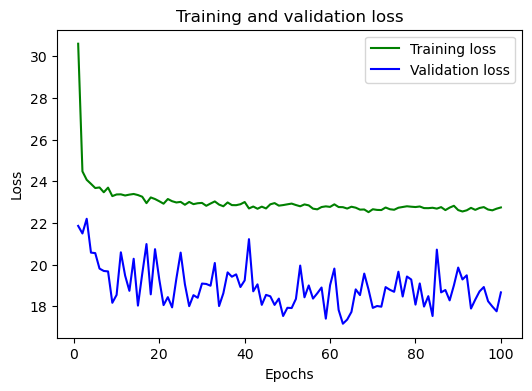

In [6]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (6,4)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.yscale('log')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
inputs_set_gyro = inputs_test_gyro
inputs_set_acc = inputs_test_acc
inputs_set_mag = inputs_test_mag
outputs_set = outputs_test

In [21]:
print([inputs_set_gyro[i].reshape(1,INPUT_FEATURE), inputs_set_acc[i].reshape(1,INPUT_FEATURE), inputs_set_mag[i].reshape(1,INPUT_FEATURE)])

[array([[  19.92167254,  215.56780041, -140.05473231]]), array([[ 0.62700414, -0.29331982, -0.01799796]]), array([[-10., -34.,  34.]])]


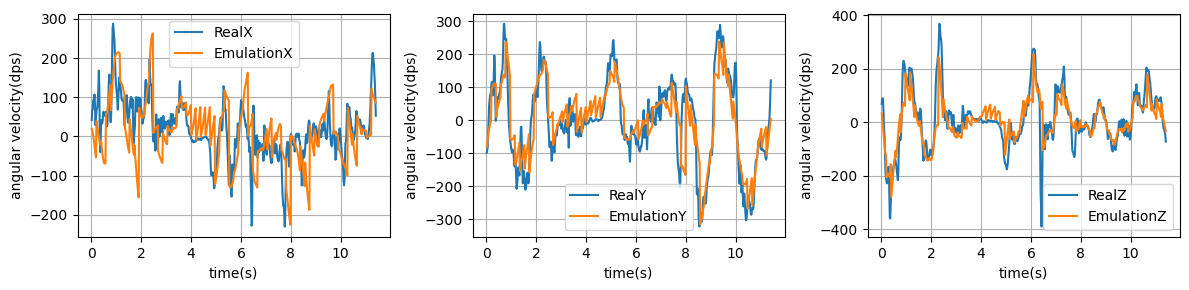

In [8]:
Emulation_x = []
Emulation_y = []
Emulation_z = []
real_x = []
real_y = []
real_z = []
# for i in range(inputs_set.shape[0] - 5):
start_item = 800
length = 600
step_size = 5
for i in range(start_item - step_size, start_item + length - step_size):
    if i % step_size == 0:
        Emulation = model.predict([inputs_set_gyro[i].reshape(1,INPUT_FEATURE), inputs_set_acc[i].reshape(1,INPUT_FEATURE), inputs_set_mag[i].reshape(1,INPUT_FEATURE)],verbose=0)
    else:
        Emulation = model.predict([Emulation.reshape(1,INPUT_FEATURE), inputs_set_acc[i].reshape(1,INPUT_FEATURE), inputs_set_mag[i].reshape(1,INPUT_FEATURE)],verbose=0)

    Emulation_x.append(Emulation[0,0])
    Emulation_y.append(Emulation[0,1])
    Emulation_z.append(Emulation[0,2])
    real_x.append(outputs_set[i][0])
    real_y.append(outputs_set[i][1])
    real_z.append(outputs_set[i][2])

# print(Emulation_x)
# print(real_x)
x_axis = np.arange(1, len(Emulation_x) + 1) / len((df['ax'])) * 300

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

# Plot data on each subplot
ax1.plot(x_axis, real_x, label = 'RealX')
ax1.plot(x_axis, Emulation_x, label = 'EmulationX')
ax1.set_xlabel('time(s)')
ax1.set_ylabel('angular velocity(dps)')
ax1.grid()
ax1.legend()

ax2.plot(x_axis, real_y, label = 'RealY')
ax2.plot(x_axis, Emulation_y, label = 'EmulationY')
ax2.set_xlabel('time(s)')
ax2.set_ylabel('angular velocity(dps)')
ax2.grid()
ax2.legend()

ax3.plot(x_axis, real_z, label = 'RealZ')
ax3.plot(x_axis, Emulation_z, label = 'EmulationZ')
ax3.set_xlabel('time(s)')
ax3.set_ylabel('angular velocity(dps)')
ax3.grid()
ax3.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [9]:
Emulation_x = []
Emulation_y = []
Emulation_z = []
real_x = []
real_y = []
real_z = []
result_x = {}
result_y = {}
result_z = {}

step_list = [1,5,10,15,20]
start_item = max(step_list) + 1
length = inputs_set_gyro.shape[0] - start_item - 5
print(length)
for step_size in step_list:
    Emulation_x = []
    Emulation_y = []
    Emulation_z = []
    real_x = []
    real_y = []
    real_z = []
    for i in range(start_item - step_size, start_item + length - step_size):
        if i % step_size == 0:
            Emulation = model.predict([inputs_set_gyro[i].reshape(1,INPUT_FEATURE), inputs_set_acc[i].reshape(1,INPUT_FEATURE), inputs_set_mag[i].reshape(1,INPUT_FEATURE)],verbose=0)
        else:
            Emulation = model.predict([Emulation.reshape(1,INPUT_FEATURE), inputs_set_acc[i].reshape(1,INPUT_FEATURE), inputs_set_mag[i].reshape(1,INPUT_FEATURE)],verbose=0)

        Emulation_x.append(Emulation[0,0])
        Emulation_y.append(Emulation[0,1])
        Emulation_z.append(Emulation[0,2])
        real_x.append(outputs_set[i][0])
        real_y.append(outputs_set[i][1])
        real_z.append(outputs_set[i][2])
    result_x[str(step_size)] = sorted([abs(a - b) for a, b in zip(Emulation_x, real_x)])
    result_y[str(step_size)] = sorted([abs(a - b) for a, b in zip(Emulation_y, real_y)])
    result_z[str(step_size)] = sorted([abs(a - b) for a, b in zip(Emulation_z, real_z)])


2340


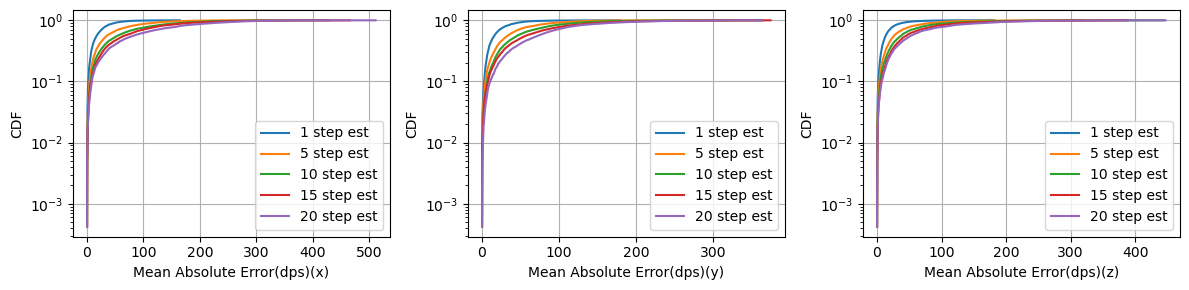

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

# Plot data on each subplot
ite = len(step_list)
for i in range(ite):
    x_axis = np.arange(1, len(result_x[str(step_list[i])]) + 1) / len(result_x[str(step_list[i])])
    ax1.plot(result_x[str(step_list[i])], x_axis,label = str(step_list[i])+' step est')
ax1.set_xlabel('Mean Absolute Error(dps)(x)')
ax1.set_ylabel('CDF')
ax1.set_yscale('log')
ax1.grid()
ax1.legend()

for i in range(ite):
    y_axis = np.arange(1, len(result_y[str(step_list[i])]) + 1) / len(result_y[str(step_list[i])])
    ax2.plot(result_y[str(step_list[i])], y_axis,label = str(step_list[i])+' step est')
ax2.set_xlabel('Mean Absolute Error(dps)(y)')
ax2.set_ylabel('CDF')
ax2.set_yscale('log')
ax2.grid()
ax2.legend()

for i in range(ite):
    z_axis = np.arange(1, len(result_z[str(step_list[i])]) + 1) / len(result_z[str(step_list[i])])
    ax3.plot(result_z[str(step_list[i])], z_axis,label = str(step_list[i])+' step est')
ax3.set_xlabel('Mean Absolute Error(dps)(z)')
ax3.set_ylabel('CDF')
ax3.set_yscale('log')
ax3.grid()
ax3.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [18]:
# # Convert the model to the TensorFlow Lite format without quantization
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model to disk
# open("Virtual_gyro_model.tflite", "wb").write(tflite_model)
  
# import os
# basic_model_size = os.path.getsize("Virtual_gyro_model.tflite")
# print("Model is %d bytes" % basic_model_size)
  
  

INFO:tensorflow:Assets written to: /tmp/tmpsc1wys27/assets


INFO:tensorflow:Assets written to: /tmp/tmpsc1wys27/assets


Model is 187820 bytes


2023-11-29 15:18:36.720437: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-11-29 15:18:36.720468: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-11-29 15:18:36.720597: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsc1wys27
2023-11-29 15:18:36.722477: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-11-29 15:18:36.722484: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsc1wys27
2023-11-29 15:18:36.728548: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-11-29 15:18:36.788673: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsc1wys27
2023-11-29 15:18:36.802893: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 82294 m

In [19]:
# !echo "const unsigned char model[] = {" > model.h
# !cat Virtual_gyro_model.tflite | xxd -i      >> model.h
# !echo "};"                              >> model.h

# import os
# model_h_size = os.path.getsize("model.h")
# print(f"Header file, model.h, is {model_h_size:,} bytes.")
# print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 1,158,258 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
